# PCA处理后的因子

- 使用pca处理资产收益率数据，取其中解释度最高的几个作为因子
- 使用国盛的数据

In [221]:
import os, sys, argparse, logging

# 设置logging格式和级别
logging.basicConfig(
    # level=logging.DEBUG,
    level=logging.INFO, 
    format='%(filename)s-line%(lineno)d %(levelname)s: %(message)s'
    )

logging.disable(logging.DEBUG)
logging.disable(logging.INFO)

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy

from sklearn.decomposition import PCA
from sklearn import preprocessing

import statsmodels.api as sm
import seaborn as sns

logging.disable(logging.NOTSET)

# 首先将framework的目录加进sys.path中，方便使用相对路径导入
framework_path = os.path.join(os.path.abspath(''), '../../../../国君研究所/工作/FOF_portfolio_toolbox/framework')
if framework_path not in sys.path:
    sys.path.append(framework_path)

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *


## 1. PCA处理因子

In [222]:
# 读入资产数据
date_range = [datetime(2009,1,1), datetime(2018,12,31)]
asset_path = os.path.join(this_path, '../data/assets')
asset_data = pd.read_csv(os.path.join(asset_path, 'guosheng_data.csv'), index_col=0)
asset_data.index = pd.to_datetime(asset_data.index)
asset_data = asset_data.loc[date_range[0]: date_range[1]]


In [223]:
asset_data = asset_data.rolling(22, min_periods=1).mean()

asset_return = asset_data.pct_change()
# normalization
mean, std = asset_return.mean(), asset_return.std()
asset_return = (asset_return - mean) / std
asset_return.iloc[0] = 0
asset_return.head(3)



,沪深300,中证500,中证1000,中债-国债总财富(总值)指数,中债-企业债总财富(总值)指数,中债-中期票据总财富(总值)指数,南华商品指数,中间价_美元兑人民币
时间,,,,,,,,
2009-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-01-06,4.404483,4.106909,3.451056,0.937775,-0.741022,-1.621575,7.080604,0.289169
2009-01-07,0.835647,1.792124,1.532268,0.690922,0.238777,-0.400249,2.800628,0.149385


In [224]:
asset_return.corr()

,沪深300,中证500,中证1000,中债-国债总财富(总值)指数,中债-企业债总财富(总值)指数,中债-中期票据总财富(总值)指数,南华商品指数,中间价_美元兑人民币
沪深300,1.000000,0.851418,0.777519,-0.222519,-0.145193,-0.091105,0.338653,-0.177253
中证500,0.851418,1.000000,0.981105,-0.171246,-0.060763,-0.022913,0.263943,-0.115395
中证1000,0.777519,0.981105,1.000000,-0.132003,-0.032552,-0.000899,0.236213,-0.099478
中债-国债总财富(总值)指数,-0.222519,-0.171246,-0.132003,1.000000,0.805980,0.793244,-0.251296,0.058760
中债-企业债总财富(总值)指数,-0.145193,-0.060763,-0.032552,0.805980,1.000000,0.947828,-0.171228,0.078532
中债-中期票据总财富(总值)指数,-0.091105,-0.022913,-0.000899,0.793244,0.947828,1.000000,-0.171821,0.084447
南华商品指数,0.338653,0.263943,0.236213,-0.251296,-0.171228,-0.171821,1.000000,0.045892
中间价_美元兑人民币,-0.177253,-0.115395,-0.099478,0.058760,0.078532,0.084447,0.045892,1.000000


In [225]:
# do pca
pca=PCA(n_components=5)  
asset_return_pca = pca.fit_transform(asset_return)
asset_return_pca = pd.DataFrame(asset_return_pca)

asset_return_pca.index = asset_data.index
asset_return_pca.columns = ['factor_{}'.format(i) for i in range(asset_return_pca.shape[1])]

asset_return_pca.head(3)

,factor_0,factor_1,factor_2,factor_3,factor_4
时间,,,,,
2009-01-05,2.996090e-15,2.557736e-14,1.636106e-15,-1.022467e-14,-3.661982e-14
2009-01-06,-7.285667e+00,-3.826233e+00,3.426633e+00,3.983299e+00,2.398829e+00
2009-01-07,-2.230097e+00,-1.839284e+00,1.431172e+00,1.597353e+00,5.748722e-01


Text(0.5, 1.0, 'conponents')

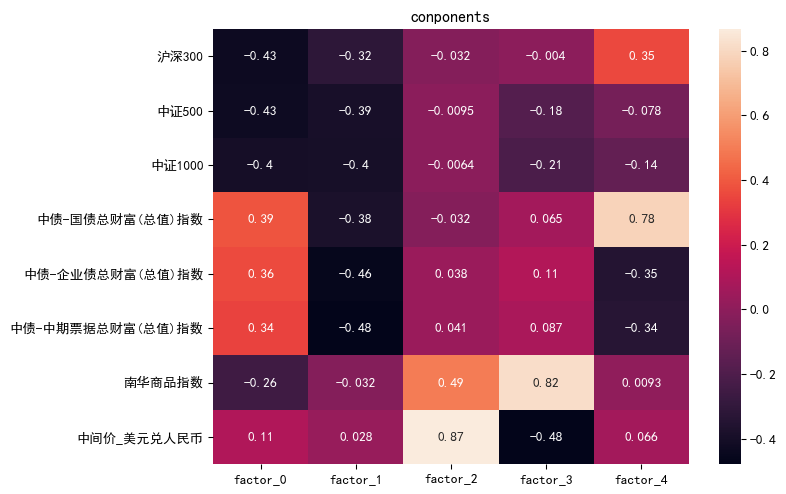

In [226]:
conponents = pd.DataFrame(pca.components_.T, columns=asset_return_pca.columns, index=asset_data.columns)

plt.figure(figsize=(8,6), dpi=96)
sns.heatmap(conponents, annot=True)
plt.title('conponents')

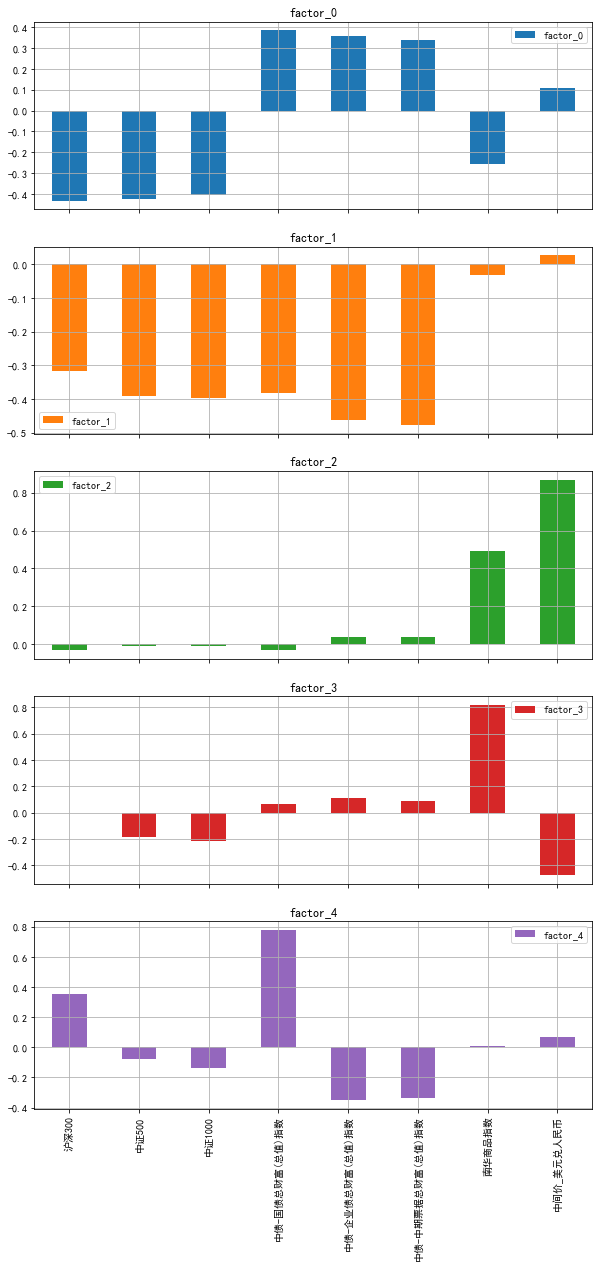

In [227]:
conponents.plot.bar(figsize=(10,20), grid=True, subplots=True)
plt.show()

In [228]:
# 解释比例
pca.explained_variance_ratio_

array([0.40029495, 0.30630929, 0.12997871, 0.09863187, 0.02921151])

<AxesSubplot:title={'center':'主成分解释比例'}>

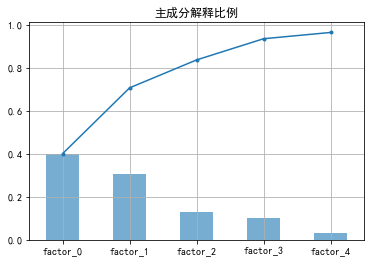

In [229]:
explained_variance_ratio = pd.Series(
    pca.explained_variance_ratio_, 
    index=conponents.columns
)
explained_variance_ratio.plot.bar(alpha=0.6)
explained_variance_ratio.cumsum().plot(grid=True, style = '.-', title='主成分解释比例')

In [230]:
asset_return_pca.corr()

,factor_0,factor_1,factor_2,factor_3,factor_4
factor_0,1.000000e+00,-6.877008e-16,1.575997e-16,1.416408e-16,2.877949e-16
factor_1,-6.877008e-16,1.000000e+00,-3.316491e-16,9.200404e-17,-1.400521e-16
factor_2,1.575997e-16,-3.316491e-16,1.000000e+00,-2.043634e-16,-1.913768e-16
factor_3,1.416408e-16,9.200404e-17,-2.043634e-16,1.000000e+00,1.116561e-16
factor_4,2.877949e-16,-1.400521e-16,-1.913768e-16,1.116561e-16,1.000000e+00


In [231]:
asset_return_pca.iloc[0] = 0
asset_data_pca = asset_return_pca / asset_return_pca.max() * 0.01
asset_data_pca += 1
asset_data_pca = asset_data_pca.cumprod()

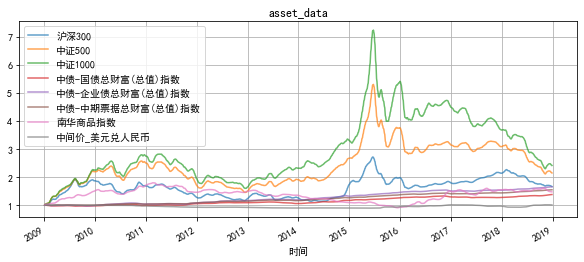

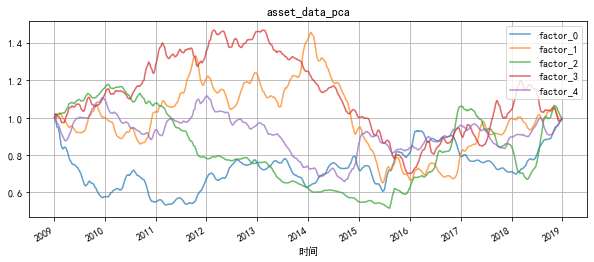

In [232]:
(asset_data / asset_data.iloc[0]).plot(alpha=0.7, grid=True, title='asset_data', figsize=(10, 4))
plt.show()
asset_data_pca.plot(alpha=0.7, grid=True, title='asset_data_pca', figsize=(10, 4))
plt.show()

<AxesSubplot:title={'center':'asset_data_pca'}, xlabel='时间'>

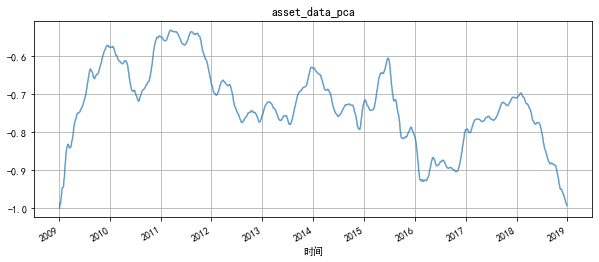

In [240]:
(-1*asset_data_pca.iloc[:,0]).plot(alpha=0.7, grid=True, title='asset_data_pca', figsize=(10, 4))

## 2. 显著性检验

每个资产收益分别对pca得到的主成分多元回归

In [234]:
asset_return_pca = (asset_return_pca-asset_return_pca.mean()) / asset_return_pca.std()
asset_return_pca = sm.add_constant(asset_return_pca)

In [235]:
exposure_df = pd.DataFrame(columns=list(asset_return_pca.columns)+['r_squre'])
for column in asset_return.columns:
    est = sm.OLS(asset_return[column], asset_return_pca.astype(float)).fit()
    exposure_df.loc[column] = list(est.params) + [est.rsquared]

# exposure_df

Text(0.5, 1.0, 'OLS results')

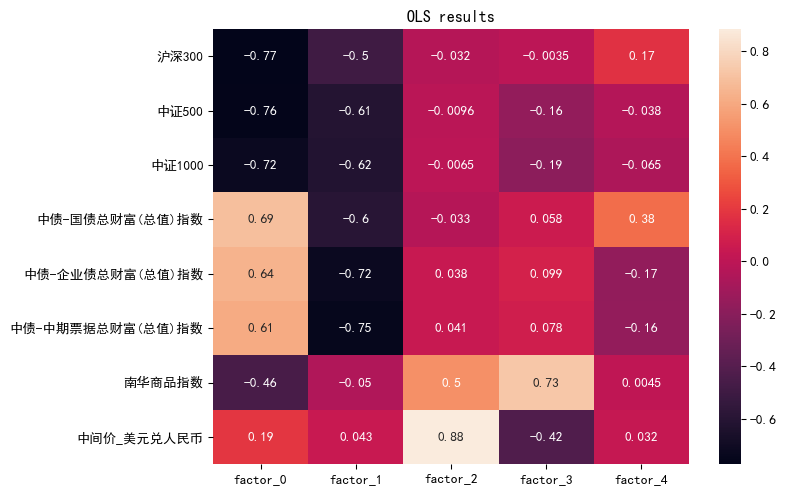

In [236]:
plt.figure(figsize=(8,6), dpi=96)
sns.heatmap(exposure_df.iloc[:, 1:-1], annot=True)
plt.title('OLS results')

In [237]:
# r_squre
exposure_df.iloc[:,-1]

沪深300               0.874997
中证500               0.984155
中证1000              0.945624
中债-国债总财富(总值)指数      0.979416
中债-企业债总财富(总值)指数     0.972256
中债-中期票据总财富(总值)指数    0.964520
南华商品指数              0.995681
中间价_美元兑人民币          0.998760
Name: r_squre, dtype: float64